
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [9]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load Metrics
from example.metrics.MazeMetrics import \
    _maze_metrics, \
    _mean_reliable_classifier_specificity

# Load Plotting Wrappers
from example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Agent - BEACS

## Environment - Maze

In [10]:
# Initialize environment
'''
maze = gym.make("MazeOntoLcs-v0")
'''
maze = gym.make("MazeOntoLcs-v0")
# Set default reward when task is achieved
maze.set_reward(1000)
# Set obstacle reward
maze.set_obstacle_reward(-300)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')


■ ■ ■ ■ ■ ■ ■
■ □ □ A □ □ ■
■ □ □ □ ■ □ ■
■ □ □ □ ■ $ ■
■ ■ ■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [11]:
%%time

cfg_explore = Configuration(
    classifier_length=8,
    number_of_possible_actions=8,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=10,
    do_pep=True,
    beta_alp=0.05,
    beta_rl=0.05,
    gamma=0.95,
    epsilon=0.8,
    u_max=8,
    mu=0.3,
    chi=0.8,
    bs_max=2
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, 1000)

agent_explore.zip_population()
population_explore = agent_explore.get_population()

Wall time: 56.3 s


### Performance

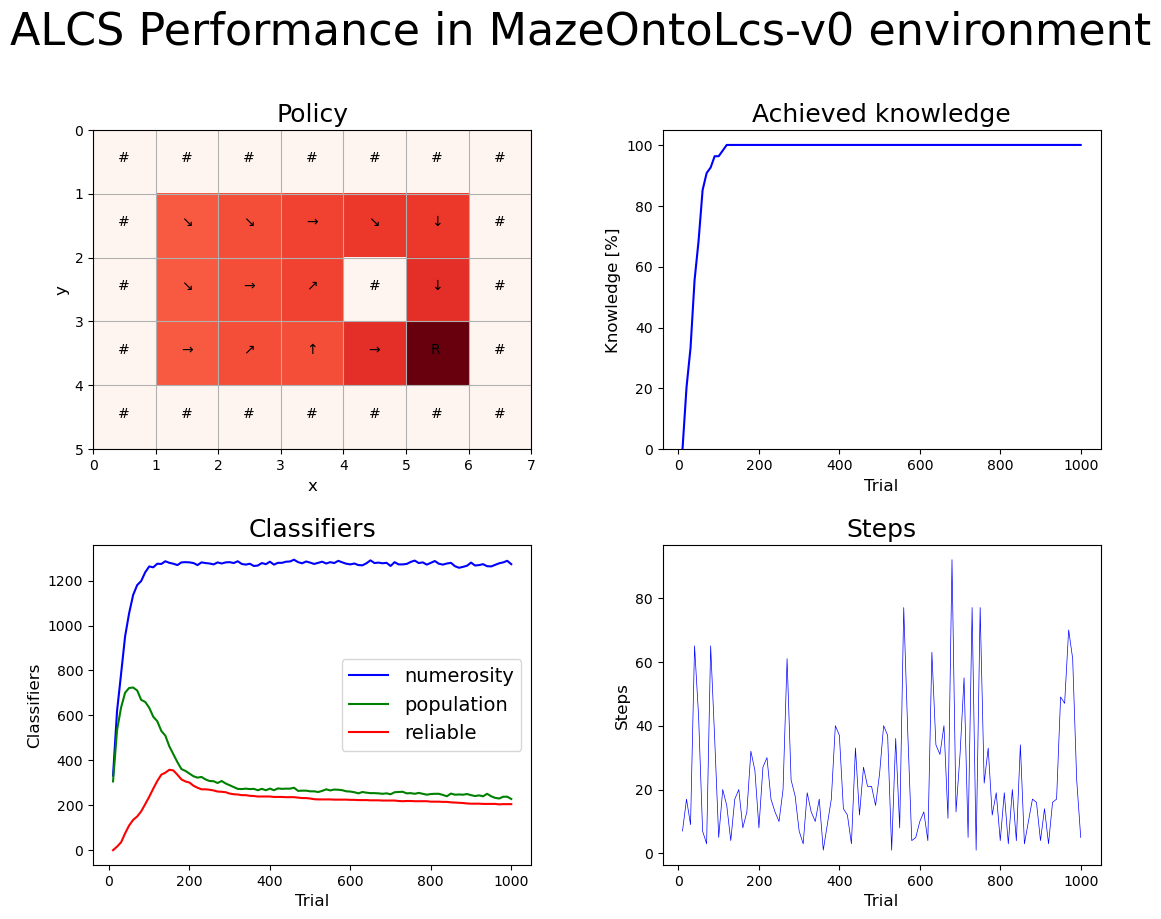

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, "MazeOntoLcs-v0", metrics_trial_frequency_explore, None)

In [13]:
print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ", _mean_reliable_classifier_specificity(population_explore, maze))

{'knowledge': 100.0, 'population': 154, 'numerosity': 1122, 'reliable': 131}
Mean reliable population specifity is  (0.38645038167938933, 0.38645038167938933, 1.0)


## Training of BEACS - Exploitation

In [14]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=8,
    number_of_possible_actions=8,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=0.05,
    gamma=0.95,
    epsilon=0.2
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, 100)

Wall time: 1.89 s


In [15]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=8,
    number_of_possible_actions=8,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=0.05,
    gamma=0.95,
    epsilon=0.0
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, 100)

Wall time: 1.16 s


In [16]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=8,
    number_of_possible_actions=8,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=0.05,
    gamma=0.95,
    epsilon=0.0,
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, 100)

Wall time: 1.79 s


### Performance

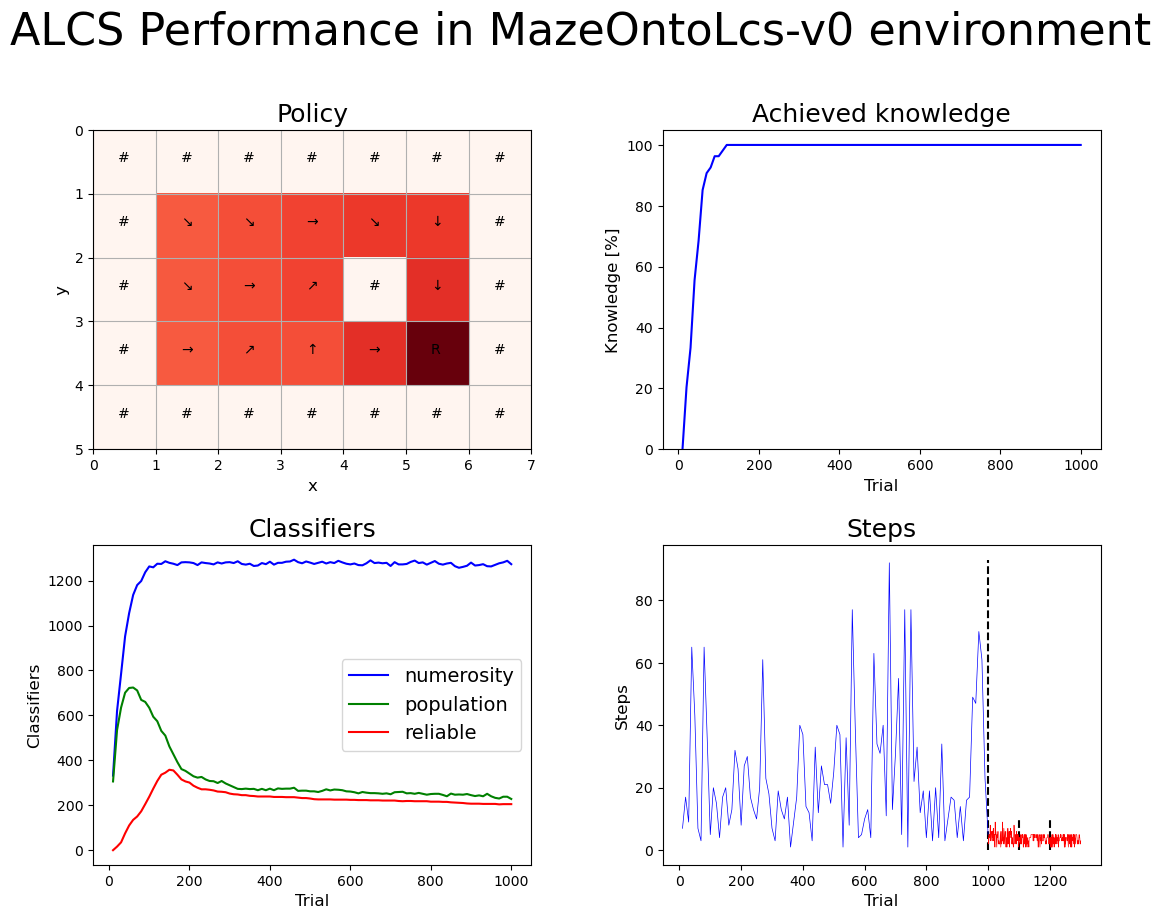

In [17]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += 100
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += 100 + 100
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, "MazeOntoLcs-v0", metrics_trial_frequency_explore, [100,100,100])

In [18]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= 1000 / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", 1000, " trials in exploration")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= 100
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", 100, " trials in first exploitation step")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= 100
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", 100, " trials in second exploitation step")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= 100
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", 100, " trials in last exploitation step")

print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  23.23  for a total of  1000  trials in exploration
Average number of steps to solve the maze is  4.13  for a total of  100  trials in first exploitation step
Average number of steps to solve the maze is  3.62  for a total of  100  trials in second exploitation step
Average number of steps to solve the maze is  3.47  for a total of  100  trials in last exploitation step
{'knowledge': 100.0, 'population': 154, 'numerosity': 1122, 'reliable': 131}


In [19]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl if cl.is_reliable()]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

131


C:####9### A:4 None E:(####1131:1)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 3.64e-07
exp: 578   num: 18 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, True, True] Aliased_state:  PAI_state: 
tga: 21599 tbseq: 1296  talp: 21669 tav: 41.76  



C:10#####0 A:2 None E:(011###31:1)
q: 1.0    ra: 1e+03  rb: 999.9  ir: 1e+03  f: 1e+03  err: 0.07183
exp: 390   num: 1 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, True, True] Aliased_state:  PAI_state: 
tga: 21674 tbseq: 979   talp: 21674 tav: 46.31  



C:##9###0# A:2 None E:(011###31:1)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.06041
exp: 386   num: 15 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, True, True] Aliased_state:  PAI_state: 
tga: 21674 tbseq: 1122  talp: 21674 tav: 46.31  



C:10#1#### A:2 None E:(011###31:1)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.06062
exp: 382   num: 1 ee